# Setup

### Load libraries

In [2]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import jinja2
import matplotlib.pyplot as plt
from weasyprint import HTML as WPHTML
from weasyprint import CSS
from html2image import Html2Image
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")
pd.reset_option("display.width")
pd.set_option('display.max_colwidth', 100)

### Load data

In [14]:
root_dirs = [
    "experiments/some_models_all_ex_defs_context",
    "experiments/grok_mini_defs_context",
    "experiments/gemini_thinking_defs_context",
    "experiments/fixing_exercises"
]

data_list = []

for root_dir in root_dirs:
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.json'):
                json_path = os.path.join(subdir, file)
                try:
                    with open(json_path, 'r') as f:
                        data = json.load(f)
                    
                    # Extract experiment name: first part after "experiments/"
                    experiment_name = os.path.normpath(subdir).split(os.sep)
                    experiment_idx = experiment_name.index("experiments") + 1
                    experiment = experiment_name[experiment_idx]
                    
                    # Extract timestamp: immediate parent folder of JSON file
                    timestamp = os.path.basename(subdir)
                    
                    # Add to data
                    data["experiment"] = experiment
                    data["timestamp"] = timestamp
                    
                    data_list.append(data)
                except json.JSONDecodeError:
                    print(f"Failed to decode JSON: {json_path}")

# Create DataFrame
df = pd.DataFrame(data_list)

# Optional: filter out unwanted models
exclude_models = ['openai/o4-mini-high', 'openai/gpt-4o-mini']
df = df[~df['model'].isin(exclude_models)]


# Drop Grok Mini models from 'some_models_all_ex_defs_context' experiment
df = df[~(
    (df['experiment'] == 'some_models_all_ex_defs_context') &
    (df['model'].str.contains("x-ai/grok-3-mini-beta"))
)]

# Drop Gemini:thinking models from 'some_models_all_ex_defs_context' experiment
df = df[~(
    (df['experiment'] == 'some_models_all_ex_defs_context') &
    (df['model'].str.contains("google/gemini-2.5-flash-preview-05-20:thinking"))
)]

# Define a composite run identifier
df['full_run_id'] = df['experiment'] + ' | ' + df['timestamp'] + ' | ' + df['run_id']

# Keep everything from fixing_exercises
df_fix = df[df['experiment'] == 'fixing_exercises']

# From all other experiments, exclude exercises starting with '2_' or '5_'
df_other = df[
    (df['experiment'] != 'fixing_exercises') &
    (~df['exercise'].str.startswith('2_')) &
    (~df['exercise'].str.startswith('5_'))
]

# Combine back together
df = pd.concat([df_fix, df_other], ignore_index=True)


len(df)


3220

In [31]:
# Natural language experiment root
nl_root_dir = "experiments/natural_language_defs_context"

# Prepare a list for the data
data_list_nl = []

# Walk through the directory tree
for subdir, _, files in os.walk(nl_root_dir):
    for file in files:
        if file.endswith('.json'):
            json_path = os.path.join(subdir, file)
            try:
                with open(json_path, 'r') as f:
                    data = json.load(f)

                # Extract experiment name
                experiment_name = os.path.normpath(subdir).split(os.sep)
                experiment_idx = experiment_name.index("experiments") + 1
                experiment = experiment_name[experiment_idx]

                # Extract timestamp
                timestamp = os.path.basename(subdir)

                # Add metadata
                data["experiment"] = experiment
                data["timestamp"] = timestamp
                data_list_nl.append(data)

            except json.JSONDecodeError:
                print(f"Failed to decode JSON: {json_path}")

# Create DataFrame
df_nl_defs = pd.DataFrame(data_list_nl)

# Define composite run ID
df_nl_defs['full_run_id'] = df_nl_defs['experiment'] + ' | ' + df_nl_defs['timestamp'] + ' | ' + df_nl_defs['run_id']

# You can now inspect or compare df_nl_defs separately
len(df_nl_defs)

159

In [36]:
# 1. Get models and exercises used in the NL experiment
nl_models = df_nl_defs['model'].unique()
nl_exercises = df_nl_defs['exercise'].unique()

# 2. Keep only rows from df where:
#    model is in NL experiment AND exercise is NOT in NL experiment
df_base_subset = df[
    (df['model'].isin(nl_models)) &
    (~df['exercise'].isin(nl_exercises))
]

# 3. Combine with NL experiment data
df_nl = pd.concat([df_base_subset, df_nl_defs], ignore_index=True)


# Case-by-case data analysis

### Inspect example data entry

In [15]:
pd.set_option('display.max_colwidth', 100)
df.iloc[0].to_frame()

,0
model,anthropic/claude-sonnet-4
exercise,5_9_1
prompt,"You are asked to write a proof in the syntax of Waterproof, a theorem proving educational softwa..."
tutorial,# Waterproof Tutorial\n\n## 1. We conclude that\n\n### Example:\n\nLemma example_reflexivity :\n...
full_input,"Your proof seems to have some mistakes in it, as it does not compile correctly.\nHere is the err..."
exercise_content,"Section Prop_5_4_1.\n\nContext (X : Metric_Space).\nNotation ""'dist(' x , y )"" := (dist X x y)\n..."
output,"Proof.\nWe need to show that (∀ ε > 0, ∃ N1 ∈ ℕ, ∀ n ≥ N1, dist(a(n), p) < ε).\nTake ε > 0.\nWe ..."
token_count,6342
input_tokens,6084
thinking_tokens,0


### See number of runs per model

In [18]:
# Count number of unique runs per model
runs_per_model = df[['model', 'full_run_id']].drop_duplicates().groupby('model').size().reset_index(name='num_runs')

# Optional: sort by num_runs descending
runs_per_model = runs_per_model.sort_values(by='num_runs', ascending=False)

# Display
runs_per_model

,model,num_runs
0,anthropic/claude-sonnet-4,27
1,google/gemini-2.5-flash-preview-05-20,27
2,google/gemini-2.5-flash-preview-05-20:thinking,27
3,openai/gpt-4.1,27
4,openai/o4-mini,27
5,x-ai/grok-3-beta,27
6,x-ai/grok-3-mini-beta,27


In [ ]:
# Count number of unique runs per model
runs_per_model_nl = df_nl[['model', 'full_run_id']].drop_duplicates().groupby('model').size().reset_index(name='num_runs')

# Optional: sort by num_runs descending
runs_per_model_nl = runs_per_model_nl.sort_values(by='num_runs', ascending=False)

# Display
runs_per_model_nl

### Inspect runs per model

In [19]:
model_to_inspect = 'google/gemini-2.5-flash-preview-05-20:thinking'

# Filter to the model of interest
df_model = df[df['model'] == model_to_inspect].copy()

# Get unique runs
unique_full_run_ids = df_model['full_run_id'].unique()

print(f"Number of unique runs for model '{model_to_inspect}': {len(unique_full_run_ids)}")

# Optionally show the run IDs for inspection
for i, run in enumerate(unique_full_run_ids):
    print(f"{i}: {run}")


Number of unique runs for model 'google/gemini-2.5-flash-preview-05-20:thinking': 27
0: fixing_exercises | 2025-06-15_00-45-03 | google/gemini-2.5-flash-preview-05-20:thinking::5_9_2::1
1: fixing_exercises | 2025-06-15_00-45-03 | google/gemini-2.5-flash-preview-05-20:thinking::2_non_degenerate_1::1
2: fixing_exercises | 2025-06-15_00-45-03 | google/gemini-2.5-flash-preview-05-20:thinking::2_positive_1::1
3: fixing_exercises | 2025-06-15_00-45-03 | google/gemini-2.5-flash-preview-05-20:thinking::2_triangle_inequality_2::1
4: fixing_exercises | 2025-06-15_00-45-03 | google/gemini-2.5-flash-preview-05-20:thinking::2_reflexive_1::1
5: fixing_exercises | 2025-06-15_00-45-03 | google/gemini-2.5-flash-preview-05-20:thinking::2_non_degenerate_2::1
6: fixing_exercises | 2025-06-15_00-45-03 | google/gemini-2.5-flash-preview-05-20:thinking::5_9_1::1
7: fixing_exercises | 2025-06-15_00-45-03 | google/gemini-2.5-flash-preview-05-20:thinking::2_symmetric_2::1
8: fixing_exercises | 2025-06-15_00-45-0

### Inspect errors in a particular run

In [20]:
# Select the Nth run (e.g. first one)
run_index = 25 # change this to pick different run
selected_full_run_id = unique_full_run_ids[run_index]

# Filter rows corresponding to this run
df_run = df_model[df_model['full_run_id'] == selected_full_run_id].sort_values(by='attempt').copy()

# Clean up error message
df_run['error_message'] = df_run['errors'].apply(
    lambda x: x.split('\n', 1)[1] if isinstance(x, str) and '\n' in x else ''
)

# Show trace table
df_run[['model', 'exercise', 'attempt', 'error_message', 'line_with_error']]


,model,exercise,attempt,error_message,line_with_error
3209,google/gemini-2.5-flash-preview-05-20:thinking,10_7_intermediate,1,,None


### Display diff between proof revisions

In [61]:
from IPython.display import display, HTML
import difflib
import html

def show_proof_diff(df_run, attempt_number_1, attempt_number_2):
    # Extract proofs
    proof_1 = df_run[df_run['attempt'] == attempt_number_1]['output'].iloc[0]
    proof_2 = df_run[df_run['attempt'] == attempt_number_2]['output'].iloc[0]

    # Extract additional info
    error_1 = df_run[df_run['attempt'] == attempt_number_1]['errors'].iloc[0]
    error_2 = df_run[df_run['attempt'] == attempt_number_2]['errors'].iloc[0]

    line_with_error_1 = df_run[df_run['attempt'] == attempt_number_1]['line_with_error'].iloc[0]
    line_with_error_2 = df_run[df_run['attempt'] == attempt_number_2]['line_with_error'].iloc[0]

    # Escape additional info
    escaped_error_1 = html.escape(error_1.split('Error:', 1)[1].strip()) if isinstance(error_1, str) and 'Error:' in error_1 else html.escape(error_1) if isinstance(error_1, str) else ''
    escaped_error_2 = html.escape(error_2.split('Error:', 1)[1].strip()) if isinstance(error_2, str) and 'Error:' in error_2 else html.escape(error_2) if isinstance(error_2, str) else ''

    escaped_line_with_error_1 = html.escape(line_with_error_1) if isinstance(line_with_error_1, str) else ''
    escaped_line_with_error_2 = html.escape(line_with_error_2) if isinstance(line_with_error_2, str) else ''

    # Split into lines and compute diff
    proof_1_lines = proof_1.splitlines()
    proof_2_lines = proof_2.splitlines()

    diff = list(difflib.ndiff(proof_1_lines, proof_2_lines))

    # Process diff for left and right columns
    left_col = []
    right_col = []

    for line in diff:
        tag = line[:2]
        content = html.escape(line[2:])  # escape <, >, &, etc.

        if tag == '  ':
            left_col.append(f"<div>{content}</div>")
            right_col.append(f"<div>{content}</div>")
        elif tag == '- ':
            left_col.append(f"<div style='background-color:#441111;'>{content}</div>")
            right_col.append(f"<div style='background-color:#222222;'></div>")
        elif tag == '+ ':
            left_col.append(f"<div style='background-color:#222222;'></div>")
            right_col.append(f"<div style='background-color:#114411;'>{content}</div>")
        elif tag == '? ':
            # ignore helper lines like ^^^^^^ in diffs
            continue

    # Combine columns into HTML → vertical layout
    html_table = f"""
    <div style="font-family: monospace; background-color: #1e1e1e; color: white; padding: 10px;">
        <div style="padding-bottom: 20px;">
            <div style="font-weight: bold; padding-bottom: 5px;">Attempt {attempt_number_1}</div>
            {''.join(left_col)}
            <div style="padding-top: 10px; color: #aaaaaa;">
                <div><b>Error:</b> {escaped_error_1}</div>
                <div><b>Line with error:</b> {escaped_line_with_error_1}</div>
            </div>
        </div>
        <div>
            <div style="font-weight: bold; padding-bottom: 5px;">Attempt {attempt_number_2}</div>
            {''.join(right_col)}
            <div style="padding-top: 10px; color: #aaaaaa;">
                <div><b>Error:</b> {escaped_error_2}</div>
                <div><b>Line with error:</b> {escaped_line_with_error_2}</div>
            </div>
        </div>
    </div>
    """

    display(HTML(html_table))


In [13]:
show_proof_diff(df_run, 2, 3)

### Total cost estimation

In [15]:
total_cost = df['cost'].sum()
total_cost

np.float64(29.492835749999998)

# Aggregate data analysis

### Success rate per model

In [21]:
# Group by model and run, compute per-run success (1 if any attempt succeeded)
per_run_success = df.groupby(['model', 'full_run_id'])['success'].max().reset_index()

# Aggregate per model: success_rate, total_runs, successful_runs
agg_success_rate = per_run_success.groupby('model')['success'].agg(['mean', 'count', 'sum']).reset_index()

# Rename columns for clarity
agg_success_rate.rename(columns={
    'mean': 'success_rate',
    'count': 'total_runs',
    'sum': 'successful_runs'
}, inplace=True)

# Convert success_rate to % for display
agg_success_rate['success_rate'] = agg_success_rate['success_rate'] * 100

# Optional: round to 1 decimal place
agg_success_rate['success_rate'] = agg_success_rate['success_rate'].round(1)

# Reorder columns: successful_runs, total_runs, success_rate, sort by success_rate descending
agg_success_rate = agg_success_rate[['model', 'successful_runs', 'total_runs', 'success_rate']].sort_values(by='success_rate', ascending=False)

# Display the table
agg_success_rate

,model,successful_runs,total_runs,success_rate
0,anthropic/claude-sonnet-4,18,27,66.7
3,openai/gpt-4.1,17,27,63.0
2,google/gemini-2.5-flash-preview-05-20:thinking,16,27,59.3
5,x-ai/grok-3-beta,15,27,55.6
1,google/gemini-2.5-flash-preview-05-20,12,27,44.4
4,openai/o4-mini,12,27,44.4
6,x-ai/grok-3-mini-beta,12,27,44.4


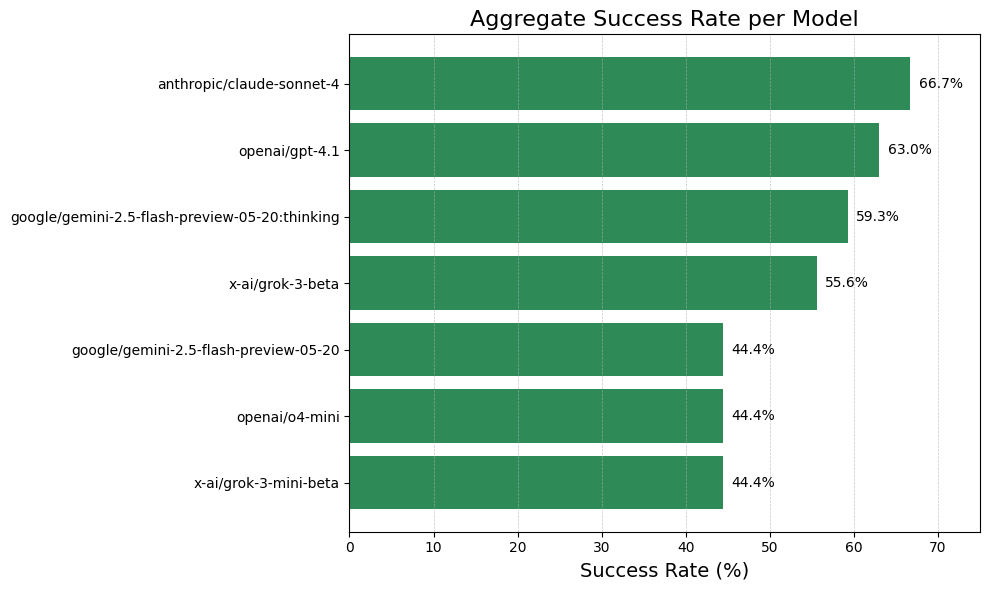

In [22]:
# Plot success_rate per model
plt.figure(figsize=(10, 6))

plt.barh(
    agg_success_rate['model'],
    agg_success_rate['success_rate'],
    color='seagreen'
)

# Invert y-axis so best model is at the top
plt.gca().invert_yaxis()

# Labels and title
plt.xlabel('Success Rate (%)', fontsize=14)
plt.xlim(0,75)
plt.title('Aggregate Success Rate per Model', fontsize=16)
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)

# Annotate bars with success rate
for i, v in enumerate(agg_success_rate['success_rate']):
    plt.text(v + 1, i, f'{v:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('visualization/success_rate_models.pdf', bbox_inches='tight')
plt.show()

In [23]:
def compute_success_rates(df_input):
    per_run_success = df_input.groupby(['model', 'full_run_id'])['success'].max().reset_index()
    agg = per_run_success.groupby('model')['success'].agg(['mean', 'count', 'sum']).reset_index()
    agg.rename(columns={
        'mean': 'success_rate',
        'count': 'total_runs',
        'sum': 'successful_runs'
    }, inplace=True)
    agg['success_rate'] = (agg['success_rate'] * 100).round(1)
    return agg[['model', 'success_rate']]


In [41]:
success_df = compute_success_rates(df)
success_nl = compute_success_rates(df_nl)

# Rename for clarity
success_df.rename(columns={'success_rate': 'Without NL'}, inplace=True)
success_nl.rename(columns={'success_rate': 'With NL'}, inplace=True)


In [42]:
# Merge on model
comparison = pd.merge(success_df, success_nl, on='model', how='inner')

# Optional: sort by 'With NL' descending
comparison = comparison.sort_values(by='With NL', ascending=False)

comparison


,model,Without NL,With NL
0,anthropic/claude-sonnet-4,66.7,77.8
1,google/gemini-2.5-flash-preview-05-20:thinking,59.3,70.4


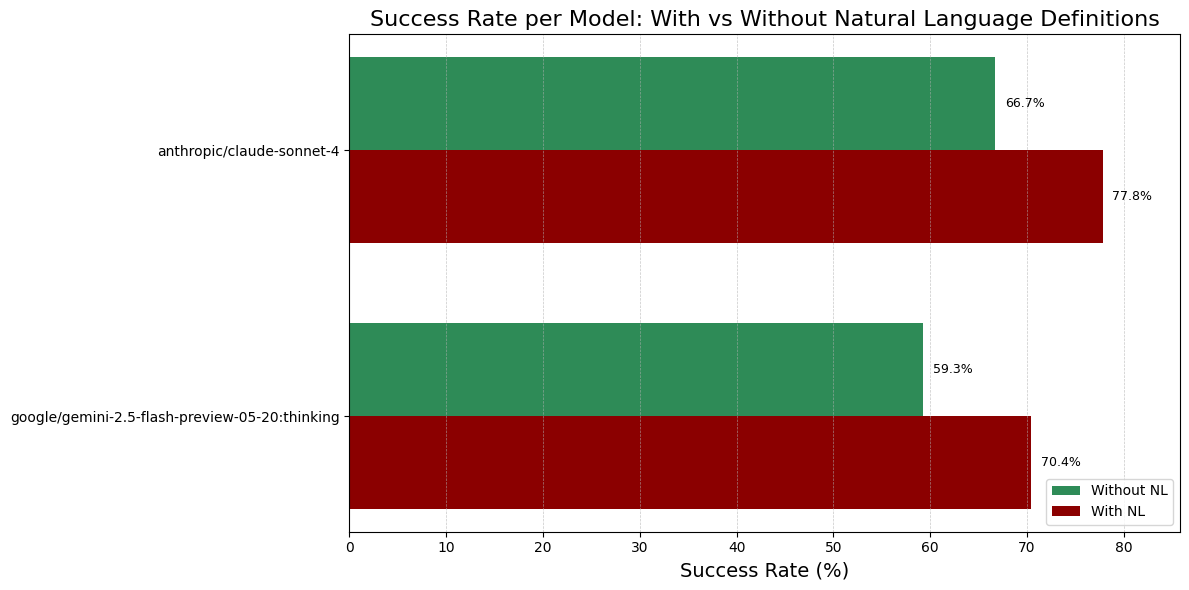

In [47]:
# Data for plotting
models = comparison['model']
x = np.arange(len(models))  # model positions
width = 0.35  # bar width

# Plot
plt.figure(figsize=(12, 6))

plt.barh(x - width/2, comparison['Without NL'], height=width, label='Without NL', color='seagreen')
plt.barh(x + width/2, comparison['With NL'], height=width, label='With NL', color='darkred')

plt.gca().invert_yaxis()

# Axis setup
plt.yticks(x, models)
plt.xlabel('Success Rate (%)', fontsize=14)
plt.title('Success Rate per Model: With vs Without Natural Language Definitions', fontsize=16)
plt.xlim(0, max(comparison[['With NL', 'Without NL']].max()) + 8)
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc='lower right')

# Annotate bars
for i in range(len(models)):
    plt.text(comparison['Without NL'].iloc[i] + 1, x[i] - width/2, f"{comparison['Without NL'].iloc[i]:.1f}%", va='center', fontsize=9)
    plt.text(comparison['With NL'].iloc[i] + 1, x[i] + width/2, f"{comparison['With NL'].iloc[i]:.1f}%", va='center', fontsize=9)

plt.tight_layout()
plt.savefig('visualization/success_rate_with_vs_without_nl.pdf', bbox_inches='tight')
plt.show()

### Success rate per exercise

In [24]:
# Group by exercise and run, compute per-run success
per_run_success_ex = df.groupby(['exercise', 'full_run_id'])['success'].max().reset_index()

# Aggregate per exercise
agg_success_rate_ex = per_run_success_ex.groupby('exercise')['success'].agg(['mean', 'count', 'sum']).reset_index()

# Rename columns for clarity
agg_success_rate_ex.rename(columns={
    'mean': 'success_rate',
    'count': 'total_runs',
    'sum': 'successful_runs'
}, inplace=True)

# Convert success_rate to % and round
agg_success_rate_ex['success_rate'] = agg_success_rate_ex['success_rate'] * 100
agg_success_rate_ex['success_rate'] = agg_success_rate_ex['success_rate'].round(1)

# Reorder columns: successful_runs, total_runs, success_rate, sort by success_rate descending
agg_success_rate_ex = agg_success_rate_ex[['exercise', 'successful_runs', 'total_runs', 'success_rate']].sort_values(by='success_rate', ascending=False)

# Display the table
agg_success_rate_ex


,exercise,successful_runs,total_runs,success_rate
2,10_7_intermediate,7,7,100.0
10,2_positive_2,7,7,100.0
9,2_positive_1,7,7,100.0
8,2_non_degenerate_2,7,7,100.0
17,3_11_1,7,7,100.0
12,2_reflexive_2,7,7,100.0
11,2_reflexive_1,7,7,100.0
13,2_symmetric_1,6,7,85.7
18,3_11_2,6,7,85.7
15,2_triangle_inequality_1,6,7,85.7


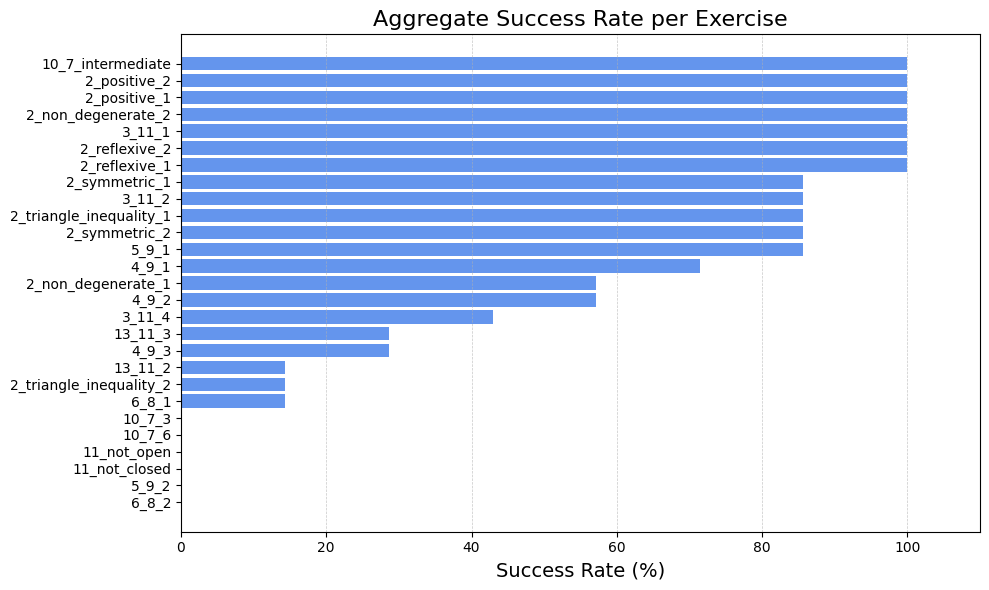

In [25]:
# Plot success_rate per exercise
plt.figure(figsize=(10, 6))

plt.barh(
    agg_success_rate_ex['exercise'],
    agg_success_rate_ex['success_rate'],
    color='cornflowerblue'
)

# Invert y-axis so best exercises appear at the top
plt.gca().invert_yaxis()

# Labels and title
plt.xlabel('Success Rate (%)', fontsize=14)
plt.xlim(0,110)
plt.title('Aggregate Success Rate per Exercise', fontsize=16)
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)

# Annotate bars with success rate
#for i, v in enumerate(agg_success_rate_ex['success_rate']):
#    plt.text(v + 1, i, f'{v:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('visualization/success_rate_exercises.pdf', bbox_inches='tight')
plt.show()


### Success rate per model and exercise

In [26]:
# Group by model, exercise, run — compute per-run success
per_run_success_grid = df.groupby(['model', 'exercise', 'full_run_id'])['success'].max().reset_index()

# Now pivot: model as rows, exercise as columns, value = mean per run (in %)
grid = per_run_success_grid.pivot_table(
    index='model',
    columns='exercise',
    values='success',
    aggfunc='mean'
) * 100

# Round nicely
grid = grid.round(1)

# Display the grid
grid


exercise,10_7_3,10_7_6,10_7_intermediate,11_not_closed,11_not_open,13_11_2,13_11_3,2_non_degenerate_1,2_non_degenerate_2,2_positive_1,...,3_11_1,3_11_2,3_11_4,4_9_1,4_9_2,4_9_3,5_9_1,5_9_2,6_8_1,6_8_2
model,,,,,,,,,,,,,,,,,,,,,
anthropic/claude-sonnet-4,0.0,0.0,100.0,0.0,0.0,0.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,0.0,100.0,100.0,0.0,100.0,0.0
google/gemini-2.5-flash-preview-05-20,0.0,0.0,100.0,0.0,0.0,100.0,0.0,100.0,100.0,100.0,...,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
google/gemini-2.5-flash-preview-05-20:thinking,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,100.0,100.0,...,100.0,100.0,0.0,100.0,100.0,100.0,100.0,0.0,0.0,0.0
openai/gpt-4.1,0.0,0.0,100.0,0.0,0.0,0.0,0.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,0.0,100.0,0.0,0.0,0.0
openai/o4-mini,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,...,100.0,100.0,0.0,100.0,100.0,0.0,100.0,0.0,0.0,0.0
x-ai/grok-3-beta,0.0,0.0,100.0,0.0,0.0,0.0,0.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,0.0,0.0,100.0,0.0,0.0,0.0
x-ai/grok-3-mini-beta,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,...,100.0,100.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0


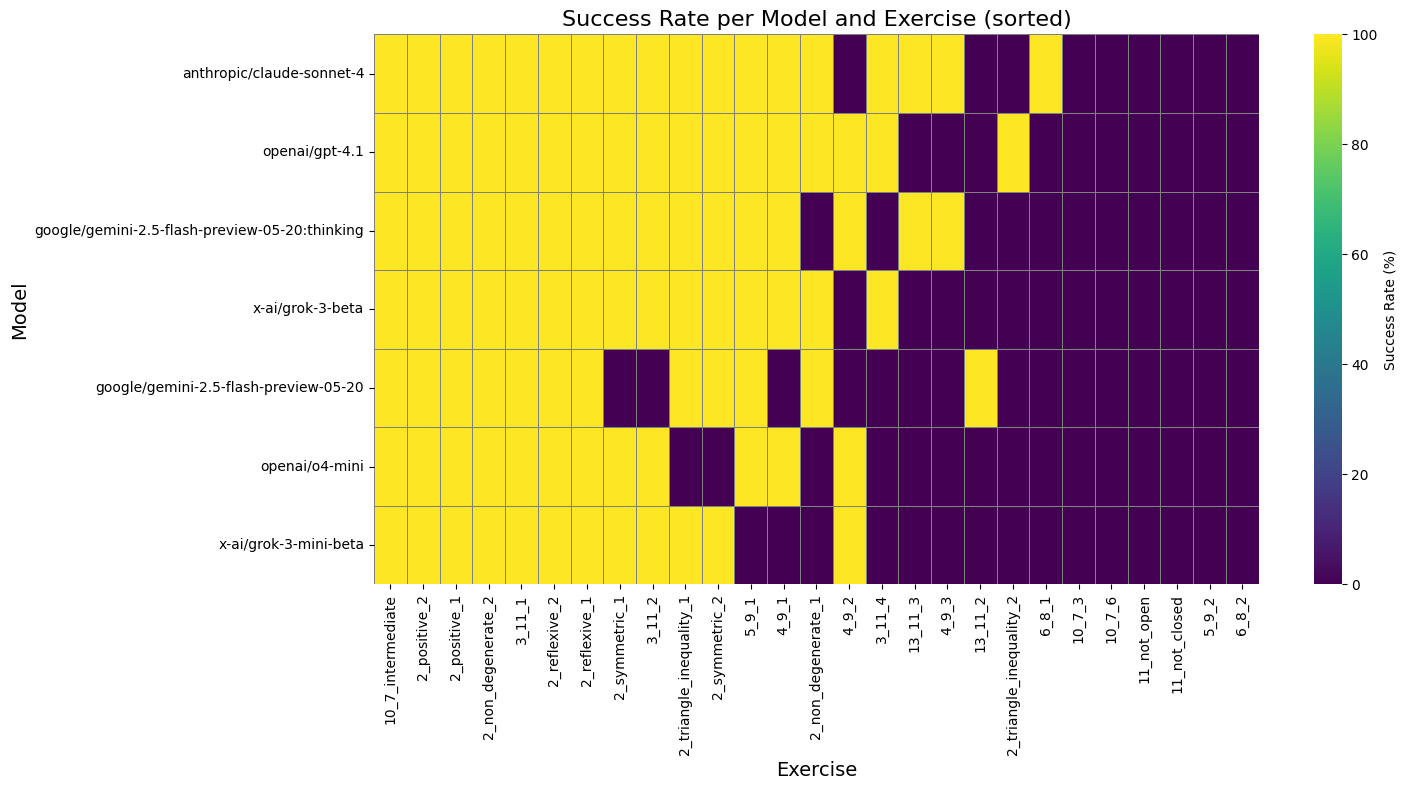

In [27]:
# Compute overall success rate per model and exercise
model_order = grid.mean(axis=1).sort_values(ascending=False).index.tolist()
exercise_order = grid.mean(axis=0).sort_values(ascending=False).index.tolist()

# Plot heatmap
plt.figure(figsize=(15, 8))

sns.heatmap(
    grid.loc[model_order, exercise_order],
    annot=False, fmt='.1f', cmap='viridis', linewidths=0.5, linecolor='gray',
    cbar_kws={'label': 'Success Rate (%)'}
)

# Labels and title
plt.xlabel('Exercise', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.title('Success Rate per Model and Exercise (sorted)', fontsize=16)

plt.tight_layout()
plt.savefig('visualization/success_rate_heatmap.pdf', bbox_inches='tight')
plt.show()


### Average output token counts per model

In [28]:
# Average output token counts per model
output_tokens_avg = df.groupby('model')['output_tokens'].mean().reset_index()
output_tokens_avg.rename(columns={'output_tokens': 'Avg Output Tokens'}, inplace=True)

# Average thinking token counts per model
thinking_tokens_avg = df.groupby('model')['thinking_tokens'].mean().reset_index()
thinking_tokens_avg.rename(columns={'thinking_tokens': 'Avg Thinking Tokens'}, inplace=True)

# Get the thinking_mode per model
thinking_mode_per_model = df[['model', 'thinking_mode']].drop_duplicates()

# Merge into the result
output_tokens_avg = output_tokens_avg.merge(thinking_mode_per_model, on='model')
output_tokens_avg = output_tokens_avg.merge(thinking_tokens_avg, on='model')

output_tokens_avg.sort_values("Avg Thinking Tokens")

,model,Avg Output Tokens,thinking_mode,Avg Thinking Tokens
0,anthropic/claude-sonnet-4,468.522059,False,0.000000
1,google/gemini-2.5-flash-preview-05-20,482.231527,False,0.000000
3,openai/gpt-4.1,446.959150,False,0.000000
5,x-ai/grok-3-beta,363.037267,False,0.000000
6,x-ai/grok-3-mini-beta,649.209141,True,4.102493
4,openai/o4-mini,336.162162,True,3093.659459
2,google/gemini-2.5-flash-preview-05-20:thinking,578.694257,True,7359.173986


### Average cost per model

In [29]:
# Define cost per attempt: group by model → mean cost
cost_per_attempt = df.groupby('model')['cost'].mean().reset_index()

# Rename column for clarity
cost_per_attempt.rename(columns={'cost': 'avg cost per attempt ($)'}, inplace=True)

# Optional: add company column
# cost_per_attempt['company'] = cost_per_attempt['model'].str.split('/').str[0]

# Display the table
cost_per_attempt.describe()


,avg cost per attempt ($)
count,7.000000
mean,0.015171
std,0.011787
min,0.003604
25%,0.006064
50%,0.009018
75%,0.024180
max,0.033088


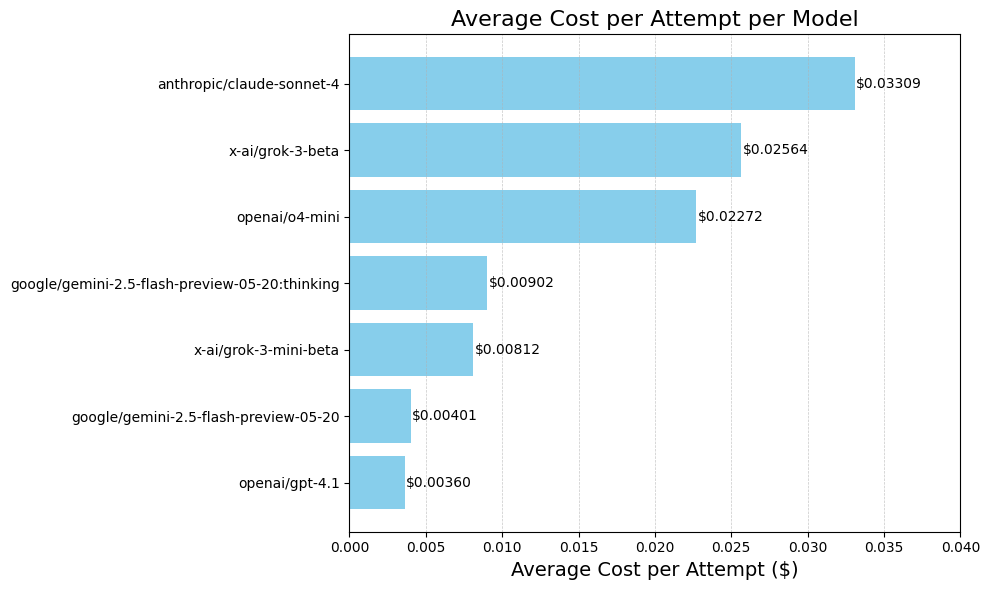

In [30]:
# Sort models by avg cost descending (optional, looks nicer)
cost_per_attempt_sorted = cost_per_attempt.sort_values(by='avg cost per attempt ($)', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(
    cost_per_attempt_sorted['model'],
    cost_per_attempt_sorted['avg cost per attempt ($)'],
    color='skyblue'
)
plt.xlim(0,0.04)

# Labels and title
plt.xlabel('Average Cost per Attempt ($)', fontsize=14)
plt.title('Average Cost per Attempt per Model', fontsize=16)
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)

# Optional: annotate bars with cost value
for i, v in enumerate(cost_per_attempt_sorted['avg cost per attempt ($)']):
    plt.text(v + 0.0001, i, f'${v:.5f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('visualization/cost_per_model.pdf', bbox_inches='tight')
plt.show()

In [31]:
# Merge success rate and cost dataframes
merged_df = agg_success_rate[['model', 'success_rate']].merge(
    cost_per_attempt[['model', 'avg cost per attempt ($)']],
    on='model'
)

# Sort by success rate (worst to best)
merged_df = merged_df.sort_values(by='success_rate')

# Display merged_df to check
merged_df


,model,success_rate,avg cost per attempt ($)
5,openai/o4-mini,44.4,0.022716
6,x-ai/grok-3-mini-beta,44.4,0.008119
4,google/gemini-2.5-flash-preview-05-20,44.4,0.004010
3,x-ai/grok-3-beta,55.6,0.025645
2,google/gemini-2.5-flash-preview-05-20:thinking,59.3,0.009018
1,openai/gpt-4.1,63.0,0.003604
0,anthropic/claude-sonnet-4,66.7,0.033088


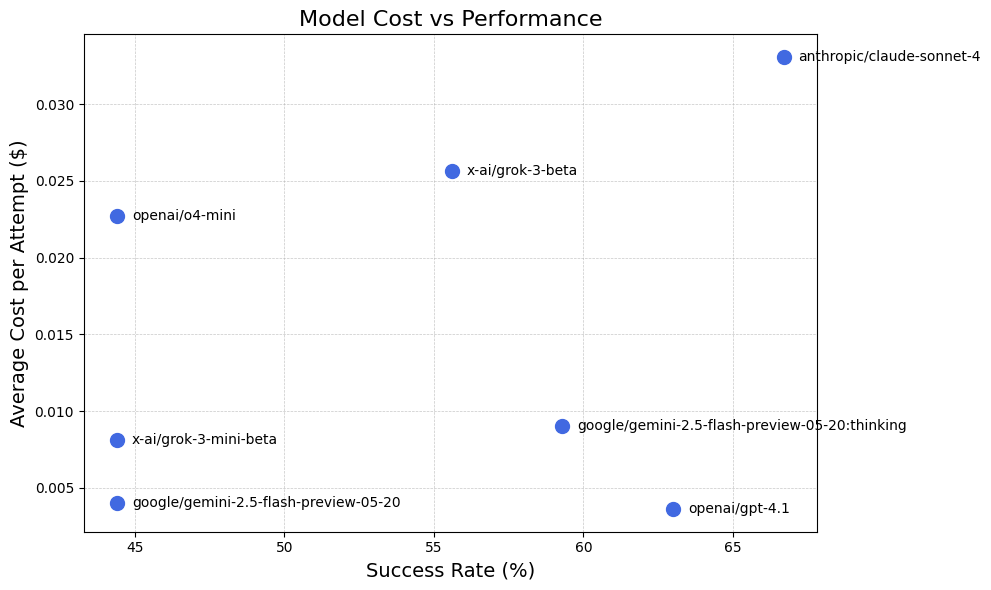

In [32]:
# Merge success rate and cost dataframes
merged_df = agg_success_rate[['model', 'success_rate']].merge(
    cost_per_attempt[['model', 'avg cost per attempt ($)']],
    on='model'
)

# Prepare x and y (no jitter)
x_values = merged_df['success_rate']
y_values = merged_df['avg cost per attempt ($)']

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, s=100, color='royalblue')

# Add model labels next to points
for i, row in merged_df.iterrows():
    plt.text(
        x_values.iloc[i] + 0.5,  # small offset to right
        y_values.iloc[i],
        row['model'],
        fontsize=10,
        va='center'
    )

# Labels and title
plt.xlabel('Success Rate (%)', fontsize=14)
plt.ylabel('Average Cost per Attempt ($)', fontsize=14)
plt.title('Model Cost vs Performance', fontsize=16)

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.savefig('visualization/cost_vs_performance.pdf', bbox_inches='tight')
plt.show()


### (WIP) Success rates with different prompt lengths

In [29]:
# Success rate per model compared across a few levels of tutorial verbosity
df['tutorial_len'] = df['tutorial'].apply(lambda x: len(x) if isinstance(x, str) else 0)

tutorial_success = df.groupby(['model', 'tutorial_len'])['success'].mean().reset_index()
tutorial_success['success'] = (tutorial_success['success'] * 100).round(2)
tutorial_success.rename(columns={'success': 'Success Rate (%)', 'tutorial_len': 'Tutorial Length'}, inplace=True)

tutorial_success

,model,Tutorial Length,Success Rate (%)
0,anthropic/claude-sonnet-4,8665,13.24
1,google/gemini-2.5-flash-preview-05-20,8665,1.48
2,google/gemini-2.5-flash-preview-05-20:thinking,8665,2.70
3,openai/gpt-4.1,8665,2.78
4,openai/o4-mini,8665,6.49
5,x-ai/grok-3-beta,8665,9.32
6,x-ai/grok-3-mini-beta,8665,1.66


### (WIP) Success rates with different tutorial lengths

In [84]:
# Success rate per model compared across a few levels of prompt verbosity
df['prompt_len'] = df['prompt'].apply(lambda x: len(x) if isinstance(x, str) else 0)

prompt_success = df.groupby(['model', 'prompt_len'])['success'].mean().reset_index()
prompt_success['success'] = (prompt_success['success'] * 100).round(2)
prompt_success.rename(columns={'success': 'Success Rate (%)', 'prompt_len': 'Prompt Length'}, inplace=True)

prompt_success

,model,Prompt Length,Success Rate (%)
0,anthropic/claude-3.7-sonnet:thinking,1422,0.00
1,anthropic/claude-sonnet-4,1422,13.64
2,deepseek/deepseek-chat-v3-0324,1422,0.00
3,deepseek/deepseek-r1-0528,1422,0.00
4,google/gemini-2.5-flash-preview-05-20,1422,0.66
5,google/gemini-2.5-flash-preview-05-20:thinking,1422,6.90
6,openai/gpt-4.1,1422,0.65
7,openai/o3-mini,1422,0.00
8,openai/o4-mini,1422,5.26
9,x-ai/grok-3-mini-beta,1422,4.76


### Aggregate pass@k metrics for each model

In [33]:
# List of (full_run_id, model, exercise, sorted list of success flags per attempt)
run_attempts = df.sort_values(['full_run_id', 'attempt']).groupby('full_run_id').agg({
    'model': 'first',
    'exercise': 'first',
    'success': lambda x: list(x),  # get list of success flags
    'attempt': 'max'  # store max_attempts per run (for correct "not used k" logic)
}).reset_index()

# Determine global max k (max number of attempts used in any run)
max_k = df['max_attempts'].max()

# Compute pass@k columns
for k in range(1, max_k + 1):
    def pass_at_k(row):
        success_flags = row['success']
        used_attempts = len(success_flags)
        success_in_k = any(success_flags[:k])
        not_used_k = used_attempts < k
        return success_in_k #or not_used_k
    
    run_attempts[f'pass@{k}'] = run_attempts.apply(pass_at_k, axis=1)

# Now compute per-model pass@k mean
passk_cols = [f'pass@{k}' for k in range(1, max_k + 1)]
passk_summary = run_attempts.groupby('model')[passk_cols].mean().reset_index()

# Convert to % and round
for col in passk_cols:
    passk_summary[col] = (passk_summary[col] * 100).round(2)

# Optional: rename columns to Pass@k (%) style
passk_summary.rename(columns={col: f'Pass@{col.split("@")[1]} (%)' for col in passk_cols}, inplace=True)

# Display
passk_summary


,model,Pass@1 (%),Pass@2 (%),Pass@3 (%),Pass@4 (%),Pass@5 (%),Pass@6 (%),Pass@7 (%),Pass@8 (%),Pass@9 (%),...,Pass@41 (%),Pass@42 (%),Pass@43 (%),Pass@44 (%),Pass@45 (%),Pass@46 (%),Pass@47 (%),Pass@48 (%),Pass@49 (%),Pass@50 (%)
0,anthropic/claude-sonnet-4,14.81,44.44,55.56,62.96,62.96,62.96,62.96,62.96,66.67,...,66.67,66.67,66.67,66.67,66.67,66.67,66.67,66.67,66.67,66.67
1,google/gemini-2.5-flash-preview-05-20,14.81,29.63,33.33,37.04,37.04,40.74,40.74,40.74,40.74,...,44.44,44.44,44.44,44.44,44.44,44.44,44.44,44.44,44.44,44.44
2,google/gemini-2.5-flash-preview-05-20:thinking,29.63,37.04,44.44,48.15,48.15,55.56,55.56,59.26,59.26,...,59.26,59.26,59.26,59.26,59.26,59.26,59.26,59.26,59.26,59.26
3,openai/gpt-4.1,11.11,25.93,33.33,40.74,44.44,44.44,44.44,44.44,44.44,...,62.96,62.96,62.96,62.96,62.96,62.96,62.96,62.96,62.96,62.96
4,openai/o4-mini,11.11,25.93,29.63,29.63,33.33,37.04,37.04,40.74,44.44,...,44.44,44.44,44.44,44.44,44.44,44.44,44.44,44.44,44.44,44.44
5,x-ai/grok-3-beta,25.93,29.63,44.44,44.44,51.85,51.85,51.85,51.85,51.85,...,55.56,55.56,55.56,55.56,55.56,55.56,55.56,55.56,55.56,55.56
6,x-ai/grok-3-mini-beta,18.52,22.22,29.63,37.04,40.74,40.74,40.74,40.74,44.44,...,44.44,44.44,44.44,44.44,44.44,44.44,44.44,44.44,44.44,44.44


### Pass@k plot

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plot_passk_summary(passk_summary, run_attempts, k_default_plot=10, show_last_marker=True):
    """
    Plot Pass@k CDF curves per model.
    - If a model used <= k_default_plot attempts, plot up to k_default_plot.
    - If a model used > k_default_plot attempts, plot up to its full max_attempts.
    - Optionally show marker on last point only.
    
    Args:
        passk_summary: DataFrame with Pass@k (%) columns (like your screenshot)
        run_attempts: DataFrame with per-run info, must include columns ['model', 'attempt']
        k_default_plot: int, default cutoff for low-attempt models (default 10)
        show_last_marker: bool, whether to show a dot on the last point of each line
    """
    # Determine max_attempts per model from run_attempts
    max_attempts_per_model = run_attempts.groupby('model')['attempt'].max().to_dict()

    # Optional: define line styles for variety
    line_styles = ['-', '--', '-.', ':']

    # Plot
    plt.figure(figsize=(12, 8))

    for i, (_, row) in enumerate(passk_summary.iterrows()):
        model_name = row['model']
        model_max_k = max_attempts_per_model.get(model_name, 50)  # fallback to 50 if missing
        
        # Determine which k to plot
        if model_max_k <= k_default_plot:
            k_plot = list(range(1, k_default_plot + 1))
        else:
            k_plot = list(range(1, model_max_k + 1))

        # Extract y values safely
        y = [row.get(f'Pass@{k} (%)', None) for k in k_plot]

        # Choose line style
        #linestyle = line_styles[(i + 2) % len(line_styles)]
        linestyle = line_styles[0]

        # Define per-model horizontal offset (small, e.g. ±0.1 or ±0.2)
        # Example: deterministic offset based on model index
        horizontal_offsets = np.linspace(-0.3, 0.3, len(passk_summary))  # spread nicely

        # Inside loop:
        offset = horizontal_offsets[i]  # pick offset for this model

        # Apply offset to x values
        x_shifted = np.array(k_plot) + offset

        # Now plot using x_shifted instead of k_plot
        plt.plot(x_shifted, y, linestyle=linestyle, linewidth=2, label=model_name)

        # Optional: marker on last point → shifted too
        if show_last_marker:
            plt.plot(x_shifted[-1], y[-1], marker='o', markersize=6)


    # Labels and title
    plt.xlabel('k (Number of attempts)', fontsize=14)
    plt.ylabel('Pass@k (%)', fontsize=14)
    plt.title(f'Pass@k Cumulative Success per Model', fontsize=16)
    
    # Legend in bottom right
    plt.legend(title='Model', fontsize=12, loc='lower right')
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.savefig('visualization/pass_at_k.pdf', bbox_inches='tight')
    plt.show()


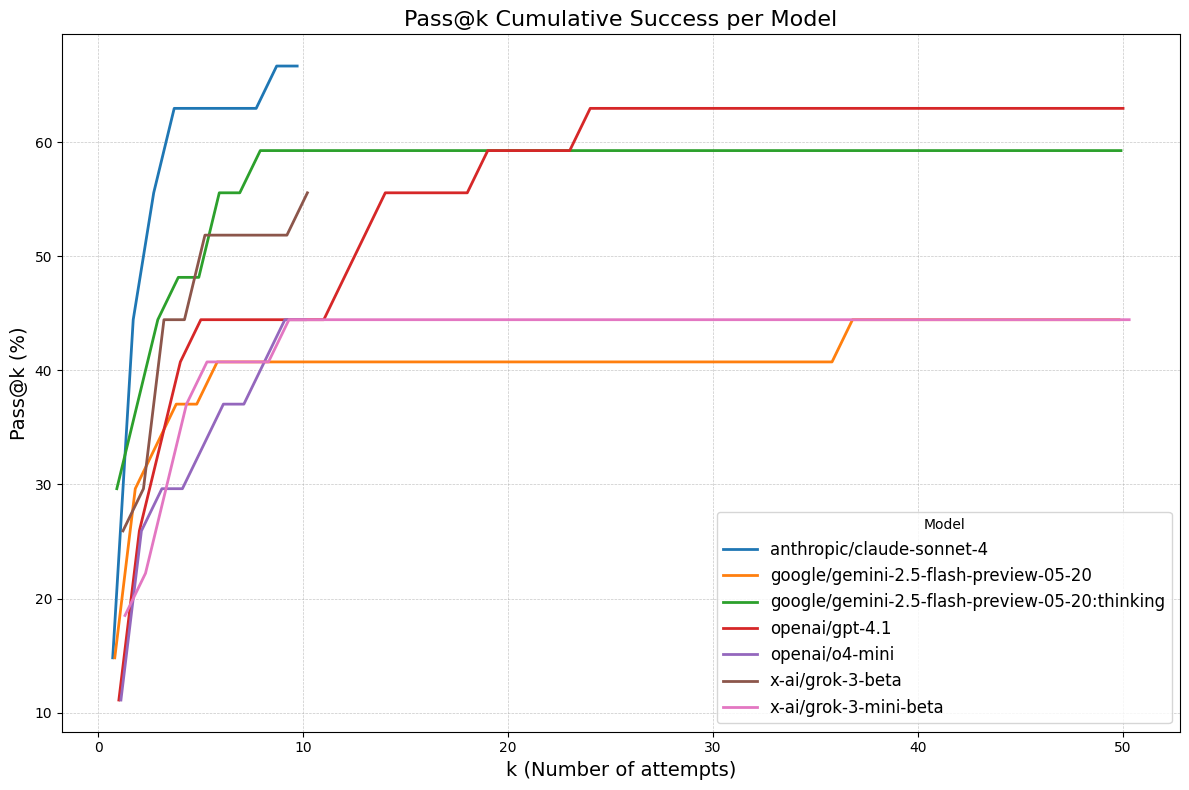

In [35]:
plot_passk_summary(passk_summary, run_attempts, k_default_plot=10, show_last_marker=False)


# Ablations

### Load ablation data

In [36]:
import os
import json
import pandas as pd

# Define ablation experiment folders
ablation_dirs = {
    "df_defs_nc": "experiments/ablation_defs_nc",
    "df_no_defs": "experiments/ablation_no_defs",
    "df_no_hints": "experiments/ablation_no_hints",
    "df_no_tutorial": "experiments/ablation_no_tutorial"
}

# Load each ablation dataset into its own DataFrame
ablation_data = {}

for name, root_dir in ablation_dirs.items():
    data_list = []
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.json'):
                json_path = os.path.join(subdir, file)
                try:
                    with open(json_path, 'r') as f:
                        data = json.load(f)

                    # Extract experiment name
                    experiment_parts = os.path.normpath(subdir).split(os.sep)
                    experiment_idx = experiment_parts.index("experiments") + 1
                    experiment = experiment_parts[experiment_idx]

                    # Extract timestamp (immediate parent folder of the JSON)
                    timestamp = os.path.basename(subdir)

                    # Attach metadata
                    data["experiment"] = experiment
                    data["timestamp"] = timestamp

                    data_list.append(data)

                except json.JSONDecodeError:
                    print(f"Failed to decode JSON: {json_path}")

    df_ablation = pd.DataFrame(data_list)

    # Define full_run_id
    df_ablation['full_run_id'] = df_ablation['experiment'] + ' | ' + df_ablation['timestamp'] + ' | ' + df_ablation['run_id']

    # Store
    ablation_data[name] = df_ablation


### Get corresponding baseline data from the main dataset

In [46]:
# Define model filter
models_of_interest = [
    "anthropic/claude-sonnet-4",
    "google/gemini-2.5-flash-preview-05-20:thinking"
]

# Define exercises per ablation
ablation_exercises = {
    "df_no_defs": [
        "10_7_intermediate", "4_9_1", "4_9_3", "5_9_1", "13_11_3"
    ],
    "df_defs_nc": [
        "10_7_intermediate", "4_9_1", "4_9_3", "5_9_1", "13_11_3"
    ],
    "df_no_hints": [
        "2_non_degenerate_2", "2_positive_1", "2_positive_2",
        "2_reflexive_1", "2_reflexive_2", "3_11_1", "10_7_intermediate"
    ],
    "df_no_tutorial": [
        "2_non_degenerate_2", "2_positive_1", "2_positive_2",
        "2_reflexive_1", "2_reflexive_2", "3_11_1"
    ]
}

# Build filtered DataFrames
baseline_data = {
    name: df[
        (df['model'].isin(models_of_interest)) &
        (df['exercise'].isin(exercises))
    ].copy()
    for name, exercises in ablation_exercises.items()
}



### Calculate side-by-side success rates per ablation

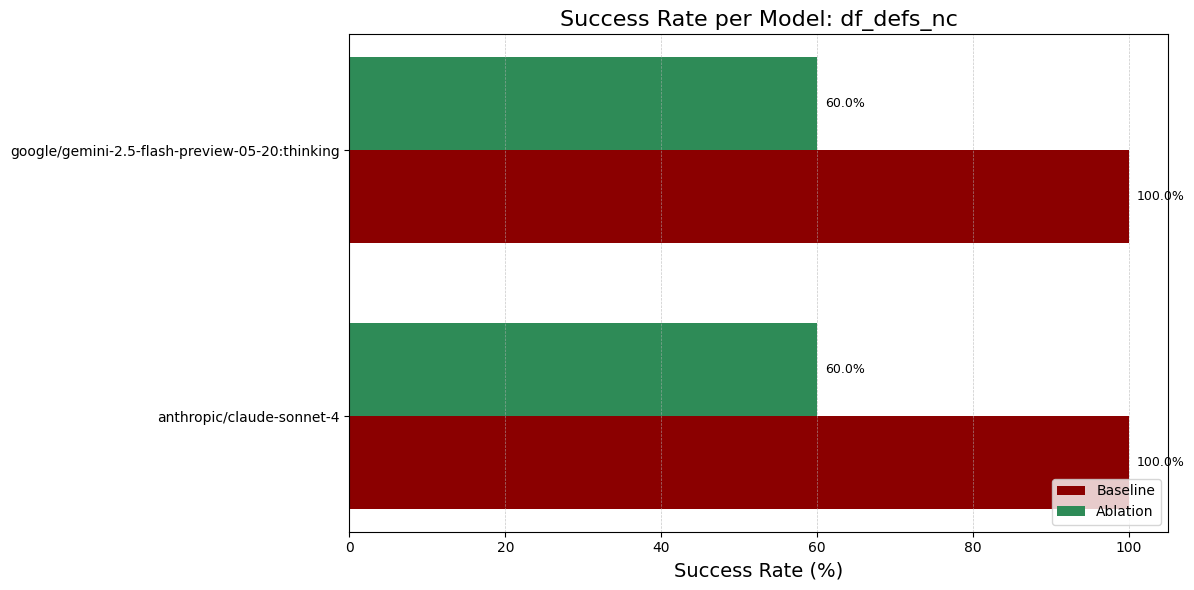


Success Rate Comparison for defs_nc:



,model,Baseline,Ablation
0,anthropic/claude-sonnet-4,100.0,60.0
1,google/gemini-2.5-flash-preview-05-20:thinking,100.0,60.0


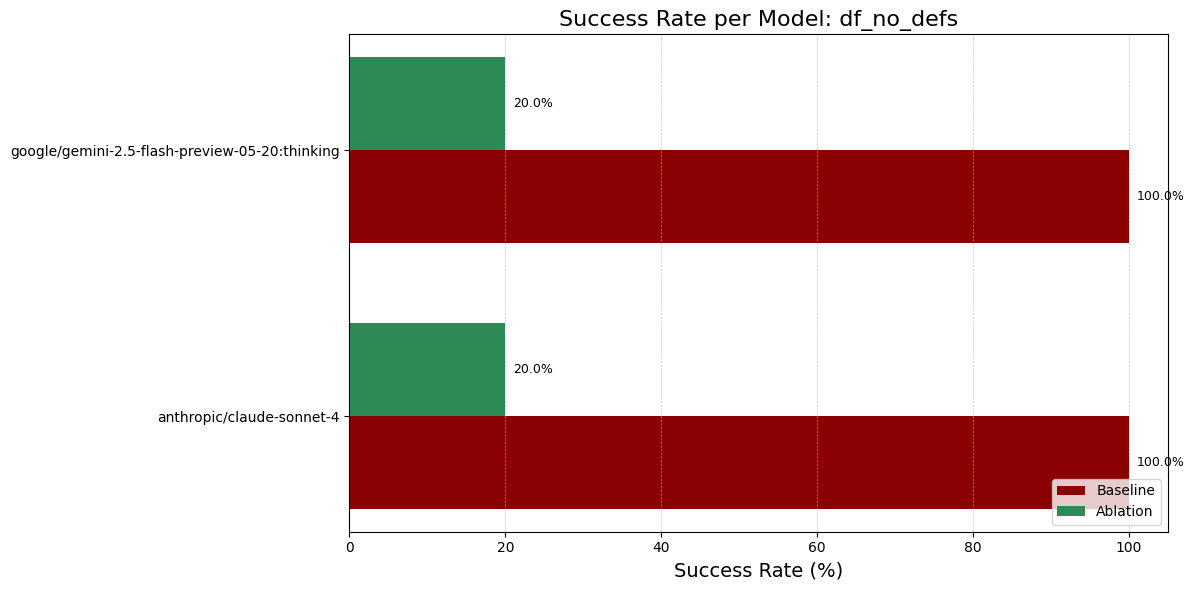


Success Rate Comparison for no_defs:



,model,Baseline,Ablation
0,anthropic/claude-sonnet-4,100.0,20.0
1,google/gemini-2.5-flash-preview-05-20:thinking,100.0,20.0


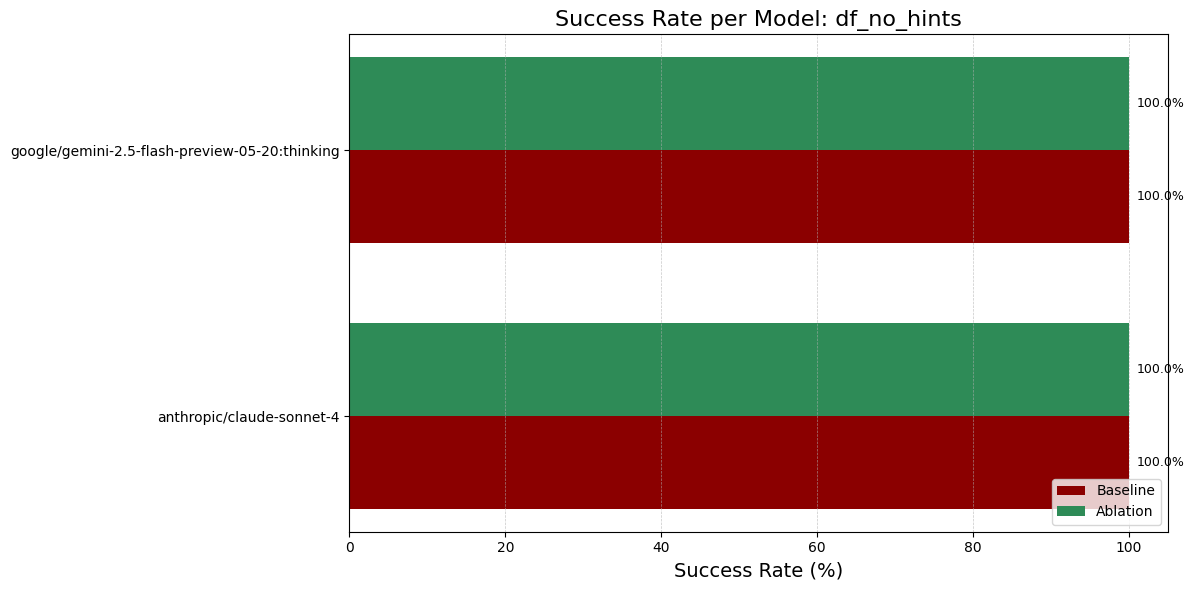


Success Rate Comparison for no_hints:



,model,Baseline,Ablation
0,anthropic/claude-sonnet-4,100.0,100.0
1,google/gemini-2.5-flash-preview-05-20:thinking,100.0,100.0


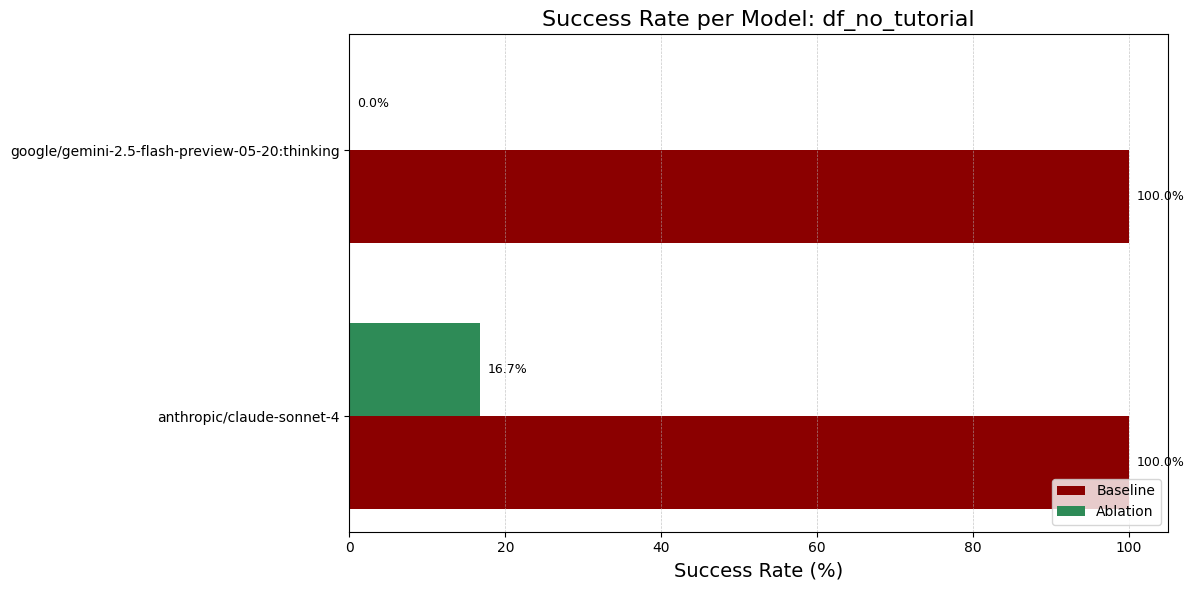


Success Rate Comparison for no_tutorial:



,model,Baseline,Ablation
0,anthropic/claude-sonnet-4,100.0,16.7
1,google/gemini-2.5-flash-preview-05-20:thinking,100.0,0.0


In [48]:
# === Success rate computation function ===
def compute_success_rates(df_input):
    per_run_success = df_input.groupby(['model', 'full_run_id'])['success'].max().reset_index()
    agg = per_run_success.groupby('model')['success'].agg(['mean', 'count', 'sum']).reset_index()
    agg.rename(columns={
        'mean': 'success_rate',
        'count': 'total_runs',
        'sum': 'successful_runs'
    }, inplace=True)
    agg['success_rate'] = (agg['success_rate'] * 100).round(1)
    return agg[['model', 'success_rate']]

# === Generate comparison plots and tables for each ablation ===
for name in ablation_data:
    df_ablation = ablation_data[name]
    df_baseline = baseline_data[name]

    # Compute success rates
    sr_ablation = compute_success_rates(df_ablation).rename(columns={'success_rate': 'Ablation'})
    sr_baseline = compute_success_rates(df_baseline).rename(columns={'success_rate': 'Baseline'})

    # Merge and sort
    comparison = pd.merge(sr_baseline, sr_ablation, on='model', how='inner')
    comparison = comparison.sort_values(by='Baseline', ascending=False)

    # === Bar Plot ===
    models = comparison['model']
    x = np.arange(len(models))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.barh(x - width/2, comparison['Baseline'], height=width, label='Baseline', color='darkred')
    plt.barh(x + width/2, comparison['Ablation'], height=width, label='Ablation', color='seagreen')

    plt.yticks(x, models)
    plt.xlabel('Success Rate (%)', fontsize=14)
    plt.title(f'Success Rate per Model: {name}', fontsize=16)
    plt.xlim(0, max(comparison[['Baseline', 'Ablation']].max()) + 5)
    plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(loc='lower right')

    for i in range(len(models)):
        plt.text(comparison['Baseline'].iloc[i] + 1, x[i] - width/2, f"{comparison['Baseline'].iloc[i]:.1f}%", va='center', fontsize=9)
        plt.text(comparison['Ablation'].iloc[i] + 1, x[i] + width/2, f"{comparison['Ablation'].iloc[i]:.1f}%", va='center', fontsize=9)

    plt.tight_layout()
    plt.savefig(f'visualization/success_rate_{name}.pdf', bbox_inches='tight')
    plt.show()

    # Display table
    display_name = name.replace('df_', '')
    print(f"\nSuccess Rate Comparison for {display_name}:\n")
    display(comparison)

### Pass@k metrics for ablations vs baseline

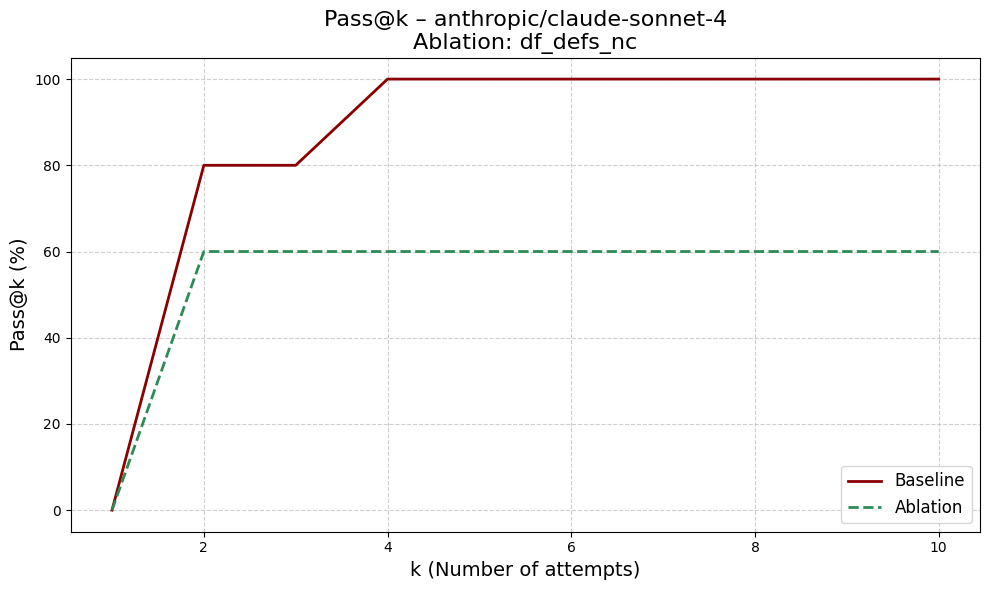

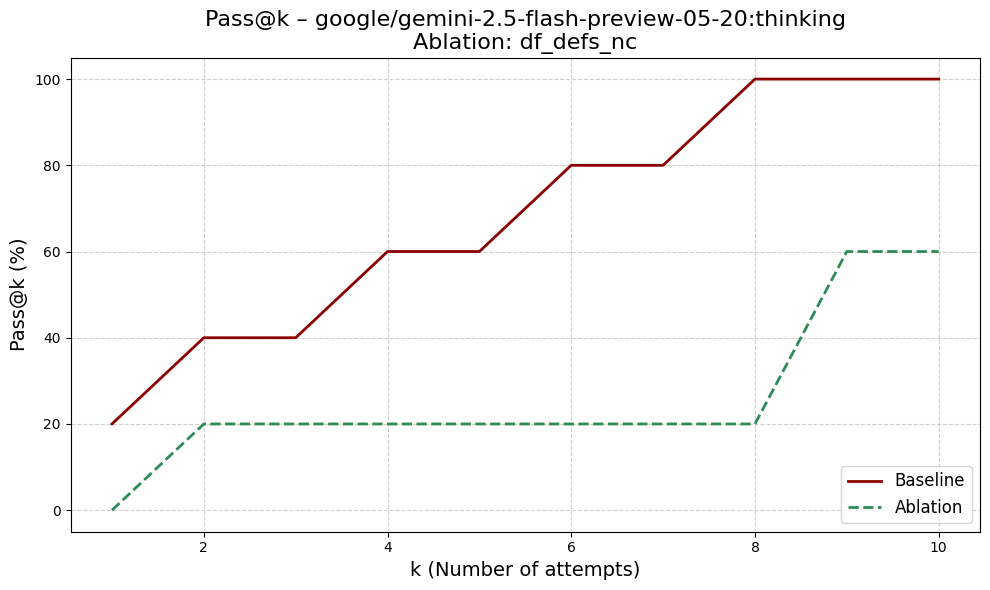

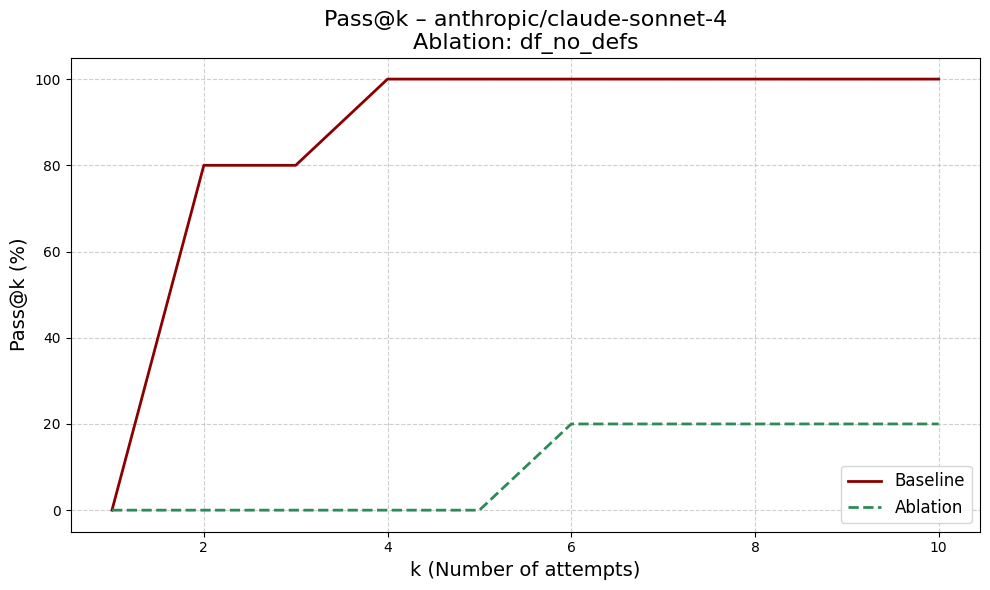

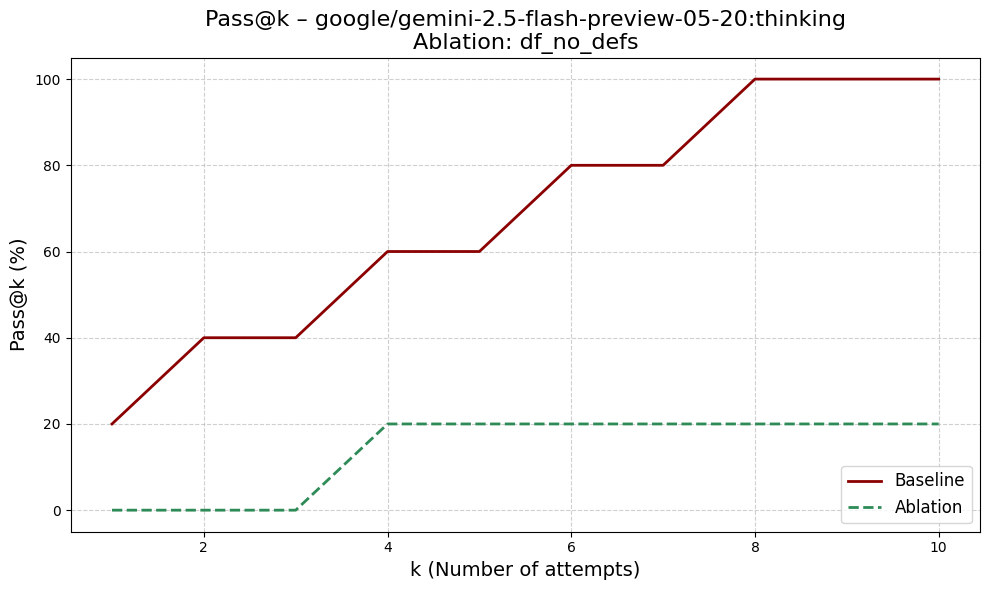

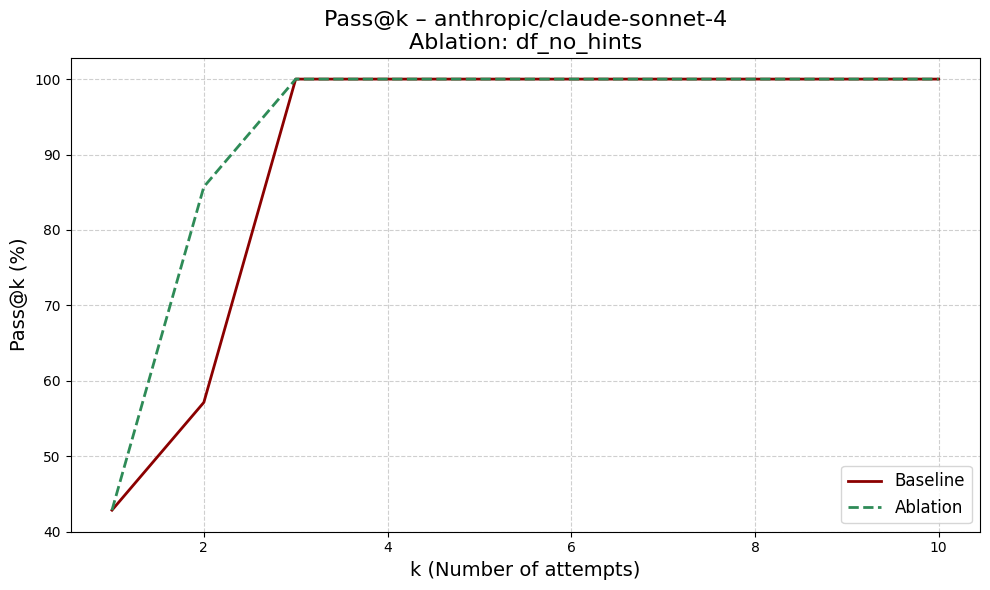

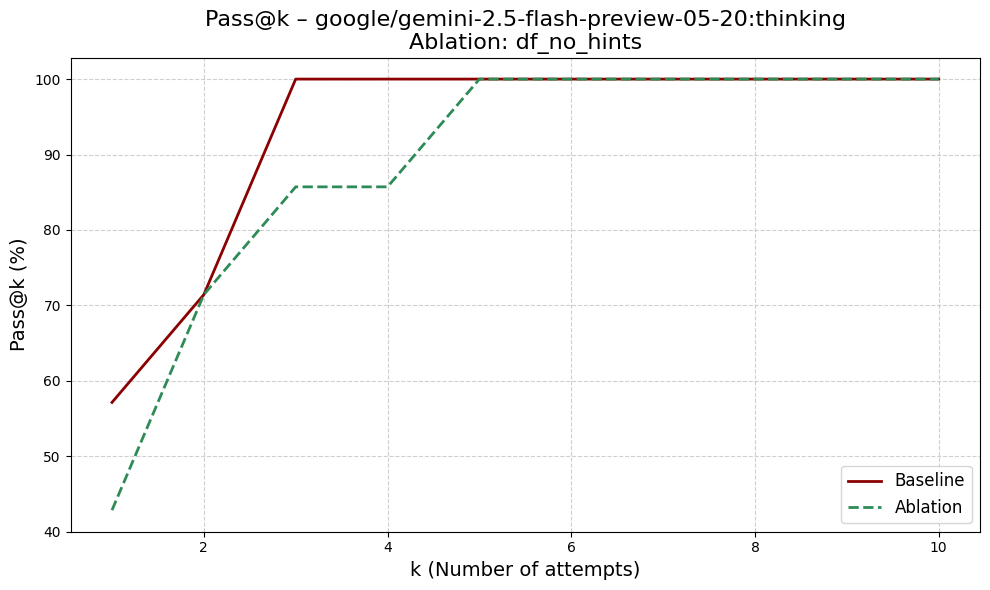

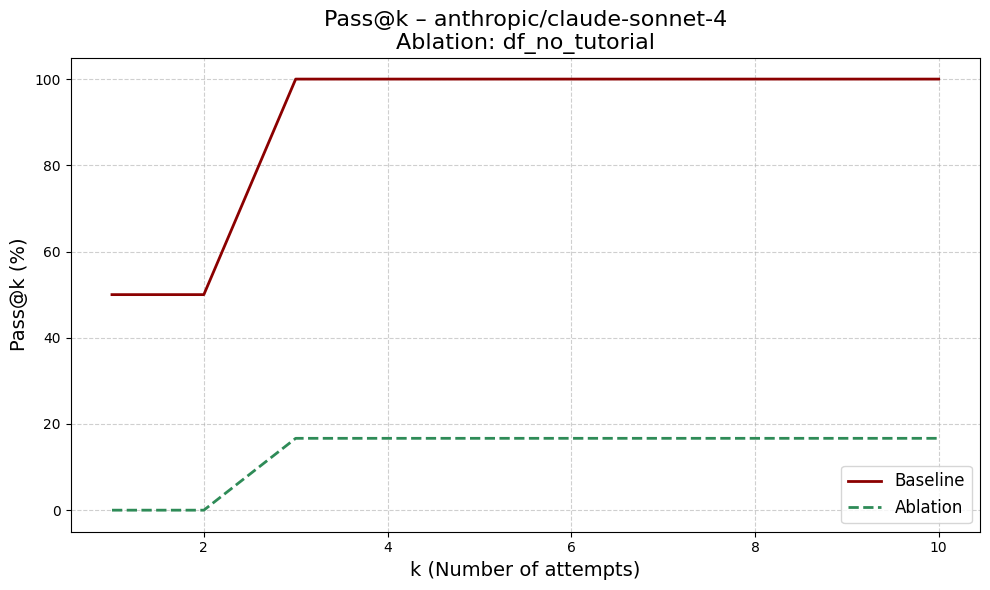

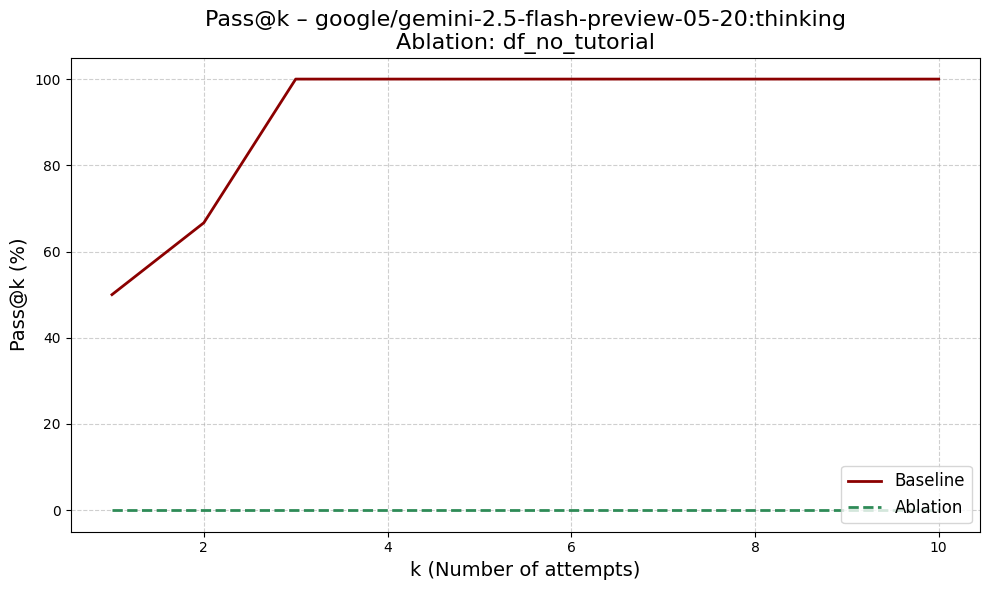

In [51]:
# Helper: recompute per-run attempt lists and pass@k values for any dataframe
def compute_passk_components(df_input, max_k=None):
    # Prepare grouped data
    run_attempts = df_input.sort_values(['full_run_id', 'attempt']).groupby('full_run_id').agg({
        'model': 'first',
        'exercise': 'first',
        'success': lambda x: list(x),
        'attempt': 'max'
    }).reset_index()

    # Determine max_k if not provided
    if max_k is None:
        max_k = df_input['max_attempts'].max()

    # Compute pass@k for each k
    for k in range(1, max_k + 1):
        run_attempts[f'pass@{k}'] = run_attempts['success'].apply(lambda flags: any(flags[:k]))

    return run_attempts, max_k

# New plotting function: compares ablation vs baseline for each model
def plot_passk_comparison(run_attempts_baseline, run_attempts_ablation, max_k, ablation_name):
    models = run_attempts_baseline['model'].unique()

    for model in models:
        base = run_attempts_baseline[run_attempts_baseline['model'] == model]
        abla = run_attempts_ablation[run_attempts_ablation['model'] == model]

        passk_cols = [f'pass@{k}' for k in range(1, max_k + 1)]
        base_mean = base[passk_cols].mean() * 100
        abla_mean = abla[passk_cols].mean() * 100

        k_range = np.arange(1, max_k + 1)

        plt.figure(figsize=(10, 6))
        plt.plot(k_range, base_mean, label='Baseline', linestyle='-', linewidth=2, color='darkred')
        plt.plot(k_range, abla_mean, label='Ablation', linestyle='--', linewidth=2, color='seagreen')

        plt.xlabel('k (Number of attempts)', fontsize=14)
        plt.ylabel('Pass@k (%)', fontsize=14)
        plt.title(f'Pass@k – {model}\nAblation: {ablation_name}', fontsize=16)
        plt.legend(loc='lower right', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()

        filename = f'visualization/pass_at_k_{ablation_name}_{model.split("/")[-1].replace(":", "_")}.pdf'
        plt.savefig(filename, bbox_inches='tight')
        plt.show()

# Run for each ablation
for ablation_name in ablation_data:
    abla_df = ablation_data[ablation_name]
    base_df = baseline_data[ablation_name]

    abla_attempts, abla_max_k = compute_passk_components(abla_df, 10)
    base_attempts, base_max_k = compute_passk_components(base_df, 10)

    max_k = max(abla_max_k, base_max_k)

    plot_passk_comparison(base_attempts, abla_attempts, max_k, ablation_name)


### Inspect ablation runs

In [52]:
model_to_inspect = 'anthropic/claude-sonnet-4'

# Filter to the model of interest
data = ablation_data['df_no_tutorial']
df_model = data[data['model'] == model_to_inspect].copy()

# Get unique runs
unique_full_run_ids = df_model['full_run_id'].unique()

print(f"Number of unique runs for model '{model_to_inspect}': {len(unique_full_run_ids)}")

# Optionally show the run IDs for inspection
for i, run in enumerate(unique_full_run_ids):
    print(f"{i}: {run}")

Number of unique runs for model 'anthropic/claude-sonnet-4': 6
0: ablation_no_tutorial | 2025-06-18_21-34-52 | anthropic/claude-sonnet-4::2_reflexive_2::1
1: ablation_no_tutorial | 2025-06-18_21-34-52 | anthropic/claude-sonnet-4::2_non_degenerate_2::1
2: ablation_no_tutorial | 2025-06-18_21-34-52 | anthropic/claude-sonnet-4::2_positive_2::1
3: ablation_no_tutorial | 2025-06-18_21-34-52 | anthropic/claude-sonnet-4::2_reflexive_1::1
4: ablation_no_tutorial | 2025-06-18_21-34-52 | anthropic/claude-sonnet-4::3_11_1::1
5: ablation_no_tutorial | 2025-06-18_21-34-52 | anthropic/claude-sonnet-4::2_positive_1::1


In [59]:
# Select the Nth run (e.g. first one)
run_index = 5 # change this to pick different run
selected_full_run_id = unique_full_run_ids[run_index]

# Filter rows corresponding to this run
df_run = df_model[df_model['full_run_id'] == selected_full_run_id].sort_values(by='attempt').copy()

# Clean up error message
df_run['error_message'] = df_run['errors'].apply(
    lambda x: x.split('\n', 1)[1] if isinstance(x, str) and '\n' in x else ''
)

# Show trace table
df_run[['model', 'exercise', 'attempt', 'error_message', 'line_with_error']]

,model,exercise,attempt,error_message,line_with_error
95,anthropic/claude-sonnet-4,2_positive_1,1,Error:\nSyntax error: [ltac_use_default] expected after [ltac2_expr] (in [ltac2_command]).\n\n,"Take x : X, y : X."
37,anthropic/claude-sonnet-4,2_positive_1,2,Error: The variable z was not found in the current environment.\n\n,"By definition_d it holds that (d(x, y) = dist_Y(f(x), f(z)))."
110,anthropic/claude-sonnet-4,2_positive_1,3,,None


In [63]:
show_proof_diff(df_run, 2, 3)

# TODOs

In [24]:
# TODO:
# thinking vs no thinking models (all)
# thinking vs no thinking on models that support both (fair)
# definition expanding comparison